In [1]:
from __future__ import division

import random
import math
import csv
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer
import argparse
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
from torchsummary import summary 

# from torch.utils.tensorboard import SummaryWriter

In [2]:
import itertools
import numpy as np
import pickle
import random
import os


# EVALUATION

## Confusion Matrix

In [ ]:
def ClassAcc(confusion_matrix):
    return confusion_matrix.diag()/confusion_matrix.sum(1)

In [ ]:
def confusion(model, loader, classes = 10):
    confusion_matrix = torch.zeros(classes, classes)
    global gpu_dtype
    global PSO_instance
    
    with torch.no_grad():
        model.eval()
        for i, (X, y) in enumerate(loader):
#             print(i)
            X = X.type(gpu_dtype)
            y = y.type(gpu_dtype)
            
            PSO_instance = PSO()
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            for t, p in zip(y.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    return(confusion_matrix.type(torch.IntTensor))     #torch.cuda.IntTensor

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
M = confusion(model, loader_test, 10)

In [ ]:
ClassAcc(M)

In [ ]:
plot_confusion_matrix(M,C)
plt.savefig('confusion_matrix_Epoch25.pdf')  

## Clustering

In [ ]:
# global images

In [ ]:
path= './TempData/ClusterEvaluation_Epoch25'

model.eval()
with torch.no_grad():
    for i, (X, y) in enumerate(loader_test):
        print(i)
        a = {}
        outputs = None

        X = X.type(gpu_dtype)
        y = y.type(gpu_dtype)

        PSO_instance = PSO()
        outputs = model(X)
    #     preds = torch.argmax(outputs, dim=1)

        a={ 'Swarm' : PSO_instance.swarm,    
            'label':  y}

        with open(path+'Batch:'+str(i)+'.pickle', 'wb') as handle:
            pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
swarm = []
images = []
labels = []

for i in range(10):
    data = None
    with open('./TempData/ClusterEvaluationBatch:{}.pickle'.format(i), 'rb') as handle:
        data = pickle.load(handle)
        swarm.append(data['Swarm']) 
#         images.append(data['images'])
        labels.append(data['label'])

In [ ]:
swarm = torch.cat(swarm)

In [ ]:
labels = torch.cat(labels)

In [ ]:
# images[0].shape

In [ ]:
@torch.no_grad()
def MY_KMeans(x, y, K=10, Niter=5, metric='manhattan'):
    
    B = x.shape[0]
    P = x.shape[1]   
    C = x.shape[2]
    H = x.shape[3]
    W = x.shape[4]
    
   
    centroid = []    
    for i in range(K):                                                            #Choosing random 10 features as centroids
        a,b = np.random.randint(B), np.random.randint(P)
        centroid.append(x[a,b].unsqueeze(0))
    centroid = torch.cat(centroid)
    

    
    labelCluster = [[] for i in range(K)]
    ImageIndex = [[] for i in range(K)]
    cos = nn.CosineSimilarity(dim=0)                                                   
    
    
    for N in range(Niter):
        cluster = [[] for i in range(K)]
        
        for i in range(B):                                    #B*P data points 
            for j in range(P):
                
                particle = x[i,j]  
                
                
                if metric == 'manhattan':
                    diff = (centroid - particle.unsqueeze(0).repeat(K,1,1,1)).abs().sum([1,2,3])       #MANHATTAN DISTANCE
                elif metric == 'eucledian':
                    diff = ((centroid - particle.unsqueeze(0).repeat(K,1,1,1))**2).sum([1,2,3])       #eucledian DISTANCE
                elif metric == 'cosine':
                    D = []
                    for ind in range(K):                                               
                        dist = 1 - cos(centroid[ind].flatten(),particle.flatten())                  #Cosine distance
                        D.append(dist)
                    diff = torch.stack(D)

                index = torch.argmin( diff )                                                 #Choosing Closest centroid
                cluster[index].append(particle.unsqueeze(0))                                #Expectation
                
                if N==(Niter-1):
                    labelCluster[index].append(int(y[i].item()))
                    ImageIndex[index].append([i,j])
                
        for i,ele in enumerate(cluster):                                                   #Maximisation
            if ele == []:
                pass
            else:
                centroid[i] = torch.cat(ele).mean(0)

    return centroid, cluster, labelCluster, ImageIndex

In [ ]:
Cent, DataCL, labelCL, ImageIndexCL = MY_KMeans(swarm, labels, 10, 10, 'cosine')

In [ ]:
C = ['plane', 'car' , 'bird', 'cat' , 'deer' , 'dog' , 'frog' , 'horse' , 'ship' , 'truck']

In [ ]:
def PrintPurity(labelCL, C):
    print('FOUND CLUSTERS HAVE FOLLOWING COMPOSITION \n')
    for i in range(10):
        print('Cluster: #' + str(i))
        n = len(labelCL[i])
        print('Cluster Size: {}'.format(n))
        c,f = np.unique(labelCL[i], return_counts=True)
        for j in range(len(c)):
            print('Class: '+ C[c[j]] + ' \t |  count: %.d'%(f[j]) + '  |   Purity (percentage): %.2f'%((f[j]/n)*100) )
        print('\n')

In [ ]:
PrintPurity(labelCL, C)

In [ ]:
# CLUSTER QUALITY

In [ ]:
def CreateSilLabels(ImageIndexCL):
    B = 10000
    P = 5
    df = np.zeros((B,P))
    for foundlabel, cl in enumerate(ImageIndexCL):
        for ele in cl:
            df[ele[0],ele[1]] = foundlabel
    
    return df.flatten() 

In [ ]:
from sklearn import metrics
metrics.silhouette_score(swarm.view(50000,-1).cpu(), CreateSilLabels(ImageIndexCL), metric='cosine')

### SINGLE CLASS CONSIDERATION 

In [ ]:
def SliceClass(swarm, labels, Class=0):
    indices = [i for i, x in enumerate(labels.cpu()) if x == Class]
    return torch.index_select(swarm, 0, torch.tensor(indices, device='cuda')), indices

In [276]:
Class_swarm, Class_absolut_indices = SliceClass(swarm, labels, 9)
classname = 'Ship'

In [258]:
# C = ['plane', 'car' , 'bird', 'cat' , 'deer' , 'dog' , 'frog' , 'horse' , 'ship' , 'truck']

In [281]:
ERR = []
with torch.no_grad():
    for k in range(1,11):
        Cent, DataCL, _, ImageIndexCL = MY_KMeans(Class_swarm, torch.ones((1000,1), device='cuda')*6 , k, 5, 'cosine')

        err = 0
        for i in range(k):
            for j in range(len(DataCL[i])):
                err+= ((DataCL[i][j] - Cent[i])**2).sum()

        ERR.append(err.item())

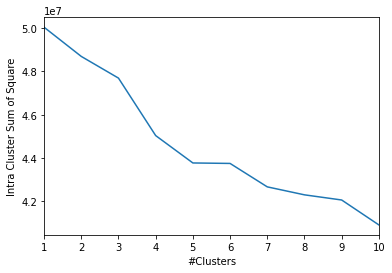

In [278]:
plt.xlabel('#Clusters')
plt.ylabel('Intra Cluster Sum of Square')
plt.xlim([1,10])
plt.plot([ERR[0]] + ERR)

In [283]:

Cent, DataCL, _, ImageIndexCL = MY_KMeans(x=Class_swarm, y=torch.ones((1000,1), device='cuda')*6 , K=5, Niter=5, metric='cosine')

In [223]:
def ClusterRepImageIndex(Cent, DataCL, ImageIndexCL):
    repImageIndex = []
    
    for i in range(len(Cent)):
        centroid = Cent[i]
        c_size = len(DataCL[i])
        diff = ((torch.cat(DataCL[i]) - Cent[i].repeat(c_size,1,1,1))**2).sum([1,2,3])
        repFeture_Index =  torch.topk(diff, k=11, largest=False)[1].cpu().numpy()      #Finds 3 most representative image indices.
        
        l1 = []      
        for ele in repFeture_Index:
            imageindex = ImageIndexCL[i][ele][0]
            if imageindex not in l1:
                l1.append(imageindex)
        
        repImageIndex.append(l1[:3])
    return repImageIndex

In [224]:
def RandomImageIndex(Rc,CL):
    for i,ele in enumerate(CL):
        l = list(np.unique([j[0] for j in ele]))

        for k in Rc[i]:
            l.remove(k)
        
        if len(l)>=5:
            s = random.sample(l,5)
        else:
            s = l
            
        Rc[i] = Rc[i] + s
    return Rc

In [225]:
def imshow(img , classname, subclusterid, eleid):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    path= './TempData/SubClustering_Epoch25_Images/{}/{}/'.format(classname, subclusterid)
    
    if not os.path.exists(path):
        os.makedirs(path)
            
    plt.savefig(path + '{}.png'.format(eleid))      


In [226]:
it = iter(loader_test)
first = next(it)
second = next(it)
third = next(it)
fourth = next(it)
fifth = next(it)
sixth = next(it)
seventh = next(it)
eighth = next(it)
ninth = next(it)
tenth = next(it)
FOLDS = [first, second, third, fourth, fifth, sixth, seventh, eighth, ninth, tenth]

In [227]:
def ManageFolds(N, FOLDS, classname, subclusterid, eleid):
    foldNumber=int(N/1000)
    fold=FOLDS[foldNumber]
    
    index = N%1000
#     print('Label- ' + str(fold[1][index].item()))
    imshow(fold[0][index], classname, subclusterid , eleid)

In [228]:
def PrintSubClusterImages():
    ImageIndexMatrix = RandomImageIndex(ClusterRepImageIndex(Cent, DataCL, ImageIndexCL), ImageIndexCL)

    for i in range(len(ImageIndexMatrix)):
        for j,ele in enumerate(ImageIndexMatrix[i]):
            ManageFolds(Class_absolut_indices[ele], FOLDS, classname, i, j)

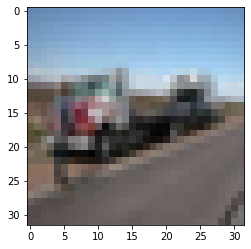

In [284]:
PrintSubClusterImages()